# Stanley cup interview analysis with Wordcloud and LSTMs

A small code that should test if an LSTM can predict if an NHL team will win the Stanley Cup based on their interviews during the cup final.

The data was taken from various places:

- Interviews: https://www.kaggle.com/dtamming/national-hockey-league-interviews
- Data of Stanley Cup teams (Players and Goalies) has been manually downloaded from the NHL homepage
- Data of Stanley Cup coaches has been taken from: https://github.com/cwils021/Stanley-Cup-Champs-1927-2019


In [45]:
# Uncomment for PDF compilation:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import itertools
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import re
import string
import xlsxwriter
import csv

import matplotlib.pyplot as plt 
from matplotlib import rcParams
plt.rcParams['figure.figsize'] = [8, 8]

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns


#NLTK libraries
import nltk
from nltk.stem.porter import PorterStemmer
from nltk import pos_tag
from nltk.corpus import wordnet
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#Deep learning libraries
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ttamfa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Data Loading

## Data of the interviews:

In [2]:
df_first = pd.read_csv("interview_data.csv")
df_first.head(20)

,RowId,team1,team2,date,name,job,text
0,0,blackhawks,lightning,2015-06-02,stan bowman,other,well we're very fortunate to have the players ...
1,1,blackhawks,lightning,2015-06-02,steve yzerman,other,no we didn't really set a timeline on it i wou...
2,2,blackhawks,lightning,2015-06-03,antoine vermette,player,that's a good question i don't recall specific...
3,3,blackhawks,lightning,2015-06-03,joel quenneville,coach,yeah we got better as the game went on i thoug...
4,4,blackhawks,lightning,2015-06-03,jon cooper,coach,i don't know i think the way i'd look at the g...
5,5,blackhawks,lightning,2015-06-04,brian boyle,player,i don't think we gave up too many grade as it ...
6,6,blackhawks,lightning,2015-06-04,joel quenneville,coach,i've been comparable throughout the years over...
7,7,blackhawks,lightning,2015-06-04,jon cooper,coach,we've had these discussions before where i've ...
8,8,blackhawks,lightning,2015-06-04,jonathan toews,player,yeah i think we know that we didn't play our b...
9,9,blackhawks,lightning,2015-06-04,steven stamkos,player,yeah i don't think we planned on losing the fi...


In [3]:
v = np.array(df_first['date'][df_first['job']!='other'])
x = np.array(df_first['name'][df_first['job']!='other'])
y = np.array(df_first['text'][df_first['job']!='other'])
z = np.array(df_first['job'][df_first['job']!='other'])

df = pd.DataFrame({'date': v, 'name':x, 'text': y,'job': z})
df.head(20)

,date,name,text,job
0,2015-06-03,antoine vermette,that's a good question i don't recall specific...,player
1,2015-06-03,joel quenneville,yeah we got better as the game went on i thoug...,coach
2,2015-06-03,jon cooper,i don't know i think the way i'd look at the g...,coach
3,2015-06-04,brian boyle,i don't think we gave up too many grade as it ...,player
4,2015-06-04,joel quenneville,i've been comparable throughout the years over...,coach
5,2015-06-04,jon cooper,we've had these discussions before where i've ...,coach
6,2015-06-04,jonathan toews,yeah i think we know that we didn't play our b...,player
7,2015-06-04,steven stamkos,yeah i don't think we planned on losing the fi...,player
8,2015-06-04,teuvo teravainen,i never heard that before i guess that's right...,player
9,2015-06-05,joel quenneville,i think he's available i think we'll probably ...,coach


## Stanley cup winners: Teams


In [4]:
df["year"] = pd.to_datetime(df["date"]).dt.year


#MISSING YEARS:
# 2005 (Lockout), 2008

#Write the year and the stanley cup winner:
years = np.unique(df["year"])
win   = ['red wings', 'red wings', 'stars', 'devils', 'avalanche', 'red wings', 'devils', 'lightning', 'hurricanes',
         'ducks', 'penguins', 'blackhawks', 'bruins', 'kings', 'blackhawks', 'kings', 'blackhawks',
        'penguins', 'penguins', 'capitals', 'blues']


#Check with dictionary if everything is correct:
d = dict(zip(years,win))

In [5]:
df

,date,name,text,job,year
0,2015-06-03,antoine vermette,that's a good question i don't recall specific...,player,2015
1,2015-06-03,joel quenneville,yeah we got better as the game went on i thoug...,coach,2015
2,2015-06-03,jon cooper,i don't know i think the way i'd look at the g...,coach,2015
3,2015-06-04,brian boyle,i don't think we gave up too many grade as it ...,player,2015
4,2015-06-04,joel quenneville,i've been comparable throughout the years over...,coach,2015
...,...,...,...,...,...
2008,2000-06-10,mike modano,i think in the last our two home games we had ...,player,2000
2009,2000-06-10,richard matvichuk,when you get to this point of the year you got...,player,2000
2010,2000-06-10,scott gomez,yeah it was in the bag laughs no it just i don...,player,2000
2011,2000-06-10,scott niedermayer,he definitely deserved it there is no doubt ab...,player,2000


## Stanley cup winners: Coaches

In [6]:
df_coaches = pd.read_csv("SCC1927-2019.csv")

x_name = "Name"
y_name = "Years"


coach_names = []
coach_years = []
for i in years:
    coach_names.append(df_coaches['Coach'][df_coaches['Year']==i].item().lower())
    coach_years.append(int(df_coaches['Year'][df_coaches['Year']==i]))
    

df_stanley_cup_winner_coach = pd.DataFrame({x_name: coach_names, y_name:coach_years})

## Stanley cup winners: Goalies


In [7]:
goalie_names = []
goalie_years = []
for i in years:
    df_tmp = pd.read_excel("./Goalies/%s.xlsx" %i)
    for j in range(len(df_tmp['Player'])):
        goalie_names.append(df_tmp['Player'][j].lower())
        goalie_years.append(int(str(df_tmp['Season'][j])[4:]))

In [8]:
df_stanley_cup_winner_goalies = pd.DataFrame({x_name: goalie_names, y_name:goalie_years})
print(df_stanley_cup_winner_goalies)

                      Name  Years
0              mike vernon   1997
1             chris osgood   1997
2             chris osgood   1998
3             kevin hodson   1998
4               ed belfour   1999
5           martin brodeur   2000
6              patrick roy   2001
7          david aebischer   2001
8            dominik hasek   2002
9             manny legace   2002
10          martin brodeur   2003
11            corey schwab   2003
12      nikolai khabibulin   2004
13            john grahame   2004
14                cam ward   2006
15           martin gerber   2006
16  jean-sebastien giguere   2007
17          ilya bryzgalov   2007
18       marc-andre fleury   2009
19           mathieu garon   2009
20             antti niemi   2010
21          cristobal huet   2010
22              tim thomas   2011
23          jonathan quick   2012
24          corey crawford   2013
25          jonathan quick   2014
26            martin jones   2014
27          corey crawford   2015
28           s

## Stanley cup winners: Players


In [9]:
player_names = []
player_years = []
for i in years:
    df_tmp = pd.read_excel("./stanleycup/%s.xlsx" %i)
    for j in range(len(df_tmp['Player'])):
        player_names.append(df_tmp['Player'][j].lower())
        player_years.append(int(str(df_tmp['Season'][j])[4:]))
        

In [10]:
df_stanley_cup_winner = pd.DataFrame({x_name: player_names, y_name:player_years})
print(df_stanley_cup_winner)

                   Name  Years
0           kris draper   1997
1        sergei fedorov   1997
2    viacheslav fetisov   1997
3         igor larionov   1997
4          larry murphy   1997
..                  ...    ...
464     carl gunnarsson   2019
465     robert bortuzzo   2019
466         sammy blais   2019
467        robby fabbri   2019
468        zach sanford   2019

[469 rows x 2 columns]


## All Stanley Cup winners:

In [11]:
total = df_stanley_cup_winner.append(df_stanley_cup_winner_coach).copy()
total = total.append(df_stanley_cup_winner_goalies).copy()

## Label the Data according to: Win/Lose the final

In [12]:
df['champions'] = np.zeros(len(df))
for i in range(len(win)):
    df["champions"][df["year"] == years[i]] = win[i]

df

,date,name,text,job,year,champions
0,2015-06-03,antoine vermette,that's a good question i don't recall specific...,player,2015,blackhawks
1,2015-06-03,joel quenneville,yeah we got better as the game went on i thoug...,coach,2015,blackhawks
2,2015-06-03,jon cooper,i don't know i think the way i'd look at the g...,coach,2015,blackhawks
3,2015-06-04,brian boyle,i don't think we gave up too many grade as it ...,player,2015,blackhawks
4,2015-06-04,joel quenneville,i've been comparable throughout the years over...,coach,2015,blackhawks
...,...,...,...,...,...,...
2008,2000-06-10,mike modano,i think in the last our two home games we had ...,player,2000,devils
2009,2000-06-10,richard matvichuk,when you get to this point of the year you got...,player,2000,devils
2010,2000-06-10,scott gomez,yeah it was in the bag laughs no it just i don...,player,2000,devils
2011,2000-06-10,scott niedermayer,he definitely deserved it there is no doubt ab...,player,2000,devils


In [13]:
df['win'] = -1
for i in range(len(df)):
    yr = df['year'][i] 
    if df['name'][i] in np.unique(np.array(total['Name'][total['Years'] == yr])):
        df['win'][i] = 1
    else:
        df['win'][i] = 0        
    
df

,date,name,text,job,year,champions,win
0,2015-06-03,antoine vermette,that's a good question i don't recall specific...,player,2015,blackhawks,1
1,2015-06-03,joel quenneville,yeah we got better as the game went on i thoug...,coach,2015,blackhawks,1
2,2015-06-03,jon cooper,i don't know i think the way i'd look at the g...,coach,2015,blackhawks,0
3,2015-06-04,brian boyle,i don't think we gave up too many grade as it ...,player,2015,blackhawks,0
4,2015-06-04,joel quenneville,i've been comparable throughout the years over...,coach,2015,blackhawks,1
...,...,...,...,...,...,...,...
2008,2000-06-10,mike modano,i think in the last our two home games we had ...,player,2000,devils,0
2009,2000-06-10,richard matvichuk,when you get to this point of the year you got...,player,2000,devils,0
2010,2000-06-10,scott gomez,yeah it was in the bag laughs no it just i don...,player,2000,devils,1
2011,2000-06-10,scott niedermayer,he definitely deserved it there is no doubt ab...,player,2000,devils,1


### 2.2 Data Description

### Total number of interviews

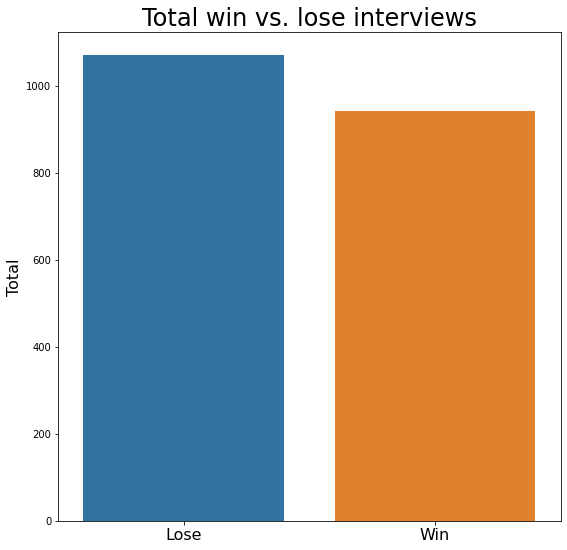

In [14]:
#Amounts of interviews 

plt.figure(figsize=(9,9))
sns.countplot(df['win'])
plt.title('Total win vs. lose interviews', fontsize=24)
plt.ylabel('Total', fontsize=16)
plt.xlabel('')
plt.xticks([0, 1], ['Lose', 'Win'], fontsize=16)

plt.show()

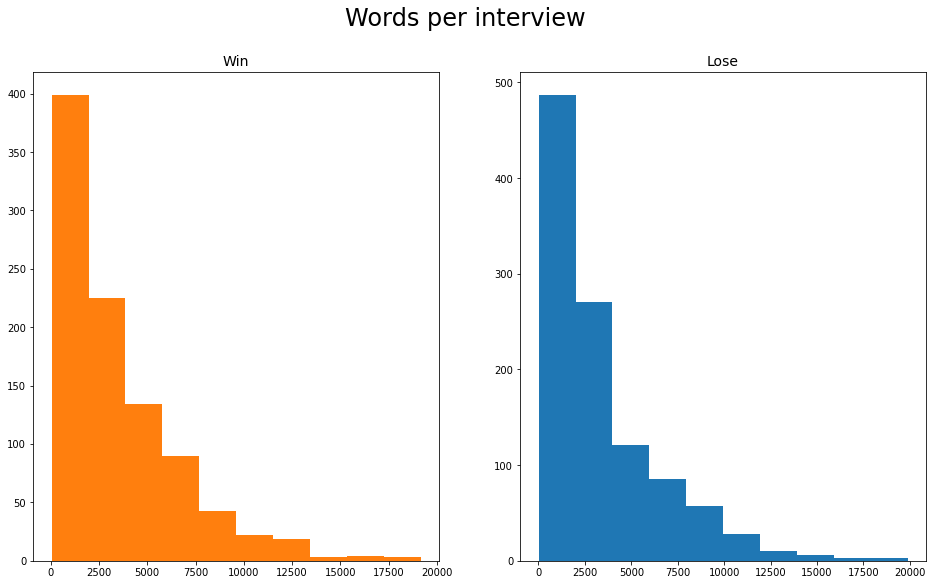

In [15]:
text_len_win  =df[df['win']==1]['text'].str.len()
text_len_lose =df[df['win']==0]['text'].str.len()

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,9))

ax1.hist(text_len_win,color='tab:orange')
ax2.hist(text_len_lose,color='tab:blue')

ax1.set_title('Win', fontsize=14)
ax2.set_title('Lose', fontsize=14)
fig.suptitle('Words per interview', fontsize=24)

plt.show()

## 2. Data cleaning

In [16]:
def word_drop(text):
    text = text.lower()
    text = re.sub("\[.*?\]", "", text)
    test = re.sub("\\W", " ", text)
    text = re.sub("https?://\S+|www\.\S+", "", text)
    text = re.sub("<.*?>+", "", text)
    text = re.sub("[%s]" % re.escape(string.punctuation), "", text)
    text = re.sub("\n", "", text)
    text = re.sub("\w*\d\w*", "", text)
    return text

In [17]:
df["text"] = df["text"].apply(word_drop)
stop = stopwords.words('english')
df["text"] = df["text"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

df.head()

,date,name,text,job,year,champions,win
0,2015-06-03,antoine vermette,thats good question dont recall specific momen...,player,2015,blackhawks,1
1,2015-06-03,joel quenneville,yeah got better game went thought second perio...,coach,2015,blackhawks,1
2,2015-06-03,jon cooper,dont know think way id look game didnt really ...,coach,2015,blackhawks,0
3,2015-06-04,brian boyle,dont think gave many grade wasnt necessarily l...,player,2015,blackhawks,0
4,2015-06-04,joel quenneville,ive comparable throughout years stretch blackh...,coach,2015,blackhawks,1


In [18]:
interviews =df[['text']].reset_index(drop=True)

#Performing stemming
ps = PorterStemmer()

for index, row in interviews.iterrows():
    text = re.sub('[^a-zA-Z]', ' ', row['text'])
    text = text.lower()
    text = text.split()
    text = [ps.stem(word) for word in text if not word in stop]
    text = ' '.join(text)
    row['text'] = text

In [19]:
interviews["text"] = interviews["text"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


## Analysis with Wordcloud

In [20]:
WIN_text  = interviews[(np.array(df['win'])== 1)]
LOSE_text  = interviews[(np.array(df['win'])== 0)]

#Just a random number:
threshold_words = 30


#WIN
wc_win = WordCloud(max_words = threshold_words, width = 1600 , height = 800).generate(" ".join(WIN_text.text))
list_of_words_win = (np.asarray(list(wc_win.words_.keys())))
list_of_freq_win  = (np.asarray(list(wc_win.words_.values())))

#LOSE
wc_lose = WordCloud(max_words = threshold_words, width = 1600 , height = 800).generate(" ".join(LOSE_text.text))
list_of_words_lose = (np.asarray(list(wc_lose.words_.keys())))
list_of_freq_lose  = (np.asarray(list(wc_lose.words_.values())))


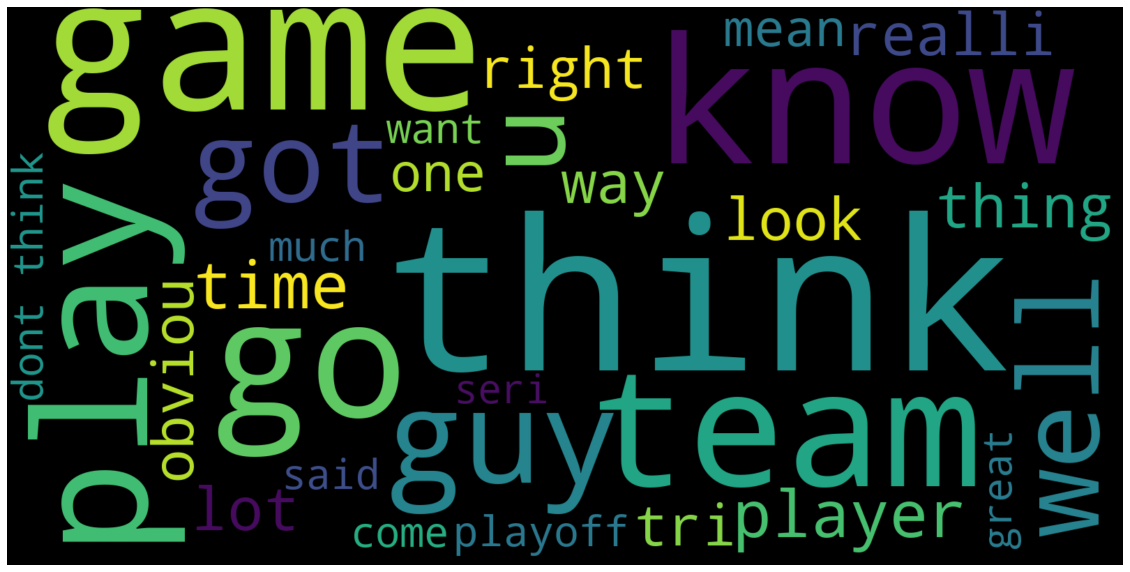

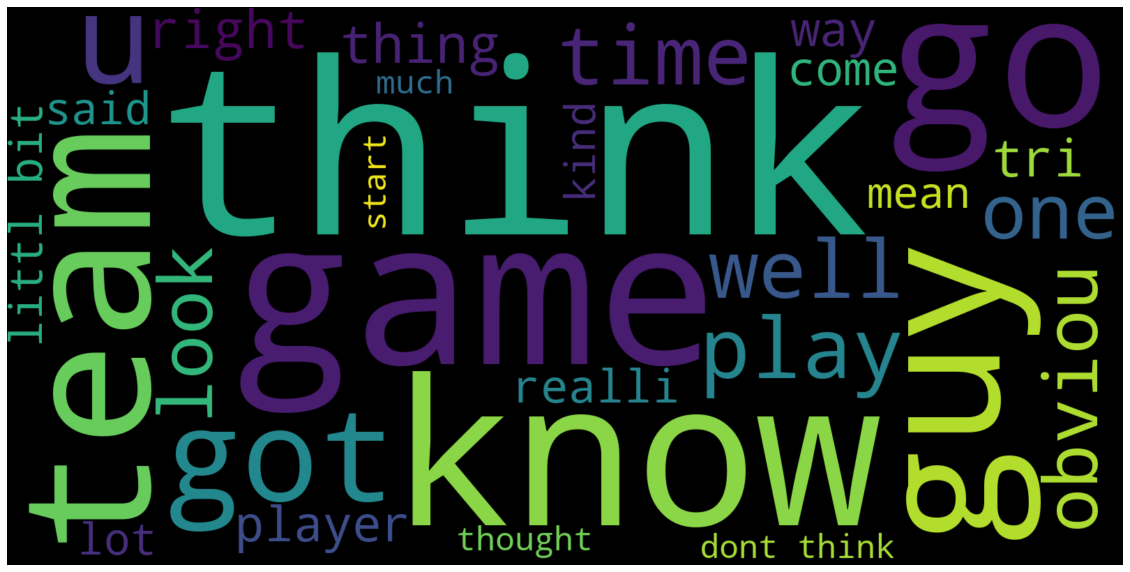

In [21]:
# PLOTS of the BEST threshold value!
plt.figure(figsize = (20,20)) # Text from the true news articles
plt.imshow(wc_win , interpolation = 'bilinear')
plt.axis("off")
plt.show()

plt.figure(figsize = (20,20)) # Text from the fake news articles
plt.imshow(wc_lose , interpolation = 'bilinear')
plt.axis("off")
plt.show()




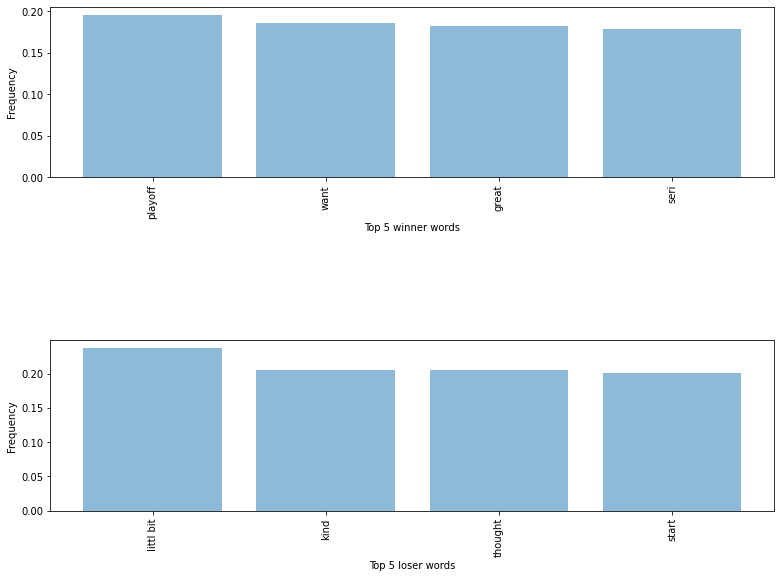

In [22]:
# Find unique values:
# In the LOSE array 
mask_lose = np.in1d(list_of_words_lose, list_of_words_win, assume_unique=True, invert=True)
new_unique_lose_list = list_of_words_lose [mask_lose]
new_unique_lose_list_freq = list_of_freq_lose[mask_lose]
# In the WIN array 
mask_win = np.in1d(list_of_words_win, list_of_words_lose, assume_unique=True, invert=True)
new_unique_win_list = list_of_words_win[mask_win]
new_unique_win_list_freq = list_of_freq_win[mask_win]


number = 5

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

ax1.bar( new_unique_win_list[:number], new_unique_win_list_freq[:number], align='center', alpha=0.5)
ax1.set_xlabel('Top %s winner words' %number)
ax1.set_ylabel('Frequency')
ax1.set_xticklabels(new_unique_win_list[:number], rotation=90)

ax2.bar( new_unique_lose_list[:number], new_unique_lose_list_freq[:number], align='center', alpha=0.5)
ax2.set_xlabel('Top %s loser words' %number)
ax2.set_ylabel('Frequency')
ax2.set_xticklabels(new_unique_lose_list[:number],rotation=90)

plt.tight_layout()
plt.subplots_adjust(top=0.85, bottom=0.15, left=0.15, wspace=0.15, hspace=.95)
plt.show()

## Finding the correct threshold

In [23]:
# Threshold loop ... want to find the optimal threshold!
# at the end of ech cycle we check the accuracy and save it to the accuracy array.
# Finally, we can pick the highest accuracy...

counter     = 0 
threshold   = [i for i in range(5,50)]
accuracy_df = pd.DataFrame(0, index=np.arange(len(threshold)), columns=['Correct','Wrong','Undefined'])

for threshold_loop in threshold:
    print('Current threshold is %s' %threshold_loop)
    wc_win = WordCloud(max_words = threshold_loop, width = 1600 , height = 800).generate(" ".join(WIN_text.text))
    list_of_words_true = (np.asarray(list(wc_win.words_.keys())))
    list_of_freq_true = (np.asarray(list(wc_win.words_.values())))

    #Fake
    wc_lose = WordCloud(max_words = threshold_loop, width = 1600 , height = 800).generate(" ".join(LOSE_text.text))
    list_of_words_lose = (np.asarray(list(wc_lose.words_.keys())))
    list_of_freq_lose = (np.asarray(list(wc_lose.words_.values())))

    # Find unique values:
    # In the fake array 
    mask_lose = np.in1d(list_of_words_lose, list_of_words_win, assume_unique=True, invert=True)
    new_unique_lose_list = list_of_words_lose[mask_lose]
    new_unique_lose_list_freq = list_of_freq_lose[mask_lose]
    # In the true array 
    mask_win = np.in1d(list_of_words_win, list_of_words_lose, assume_unique=True, invert=True)
    new_unique_win_list = list_of_words_win[mask_win]
    new_unique_win_list_freq = list_of_freq_win[mask_win]

    # TESTING:
    # Making the mask's
    mask_win      = (df['text'].str.contains('|'.join(new_unique_win_list)))
    mask_win_real = (df['win']==1) 
    mask_lose      = (df['text'].str.contains('|'.join(new_unique_lose_list)))
    mask_lose_real = (df['win']==0) 

    # Finding the accuracy:
    accuracy_df['Undefined'][counter] = len(df[mask_win & mask_lose]) + len(df[~mask_win & ~mask_lose])
    right1  = len( df[(mask_win & mask_win_real) & ~mask_lose ])  
    right2  = len( df[(mask_lose & mask_lose_real) & ~mask_win]) 
    accuracy_df['Correct'][counter]    = right1 +right2
    false1  = len( df[(mask_win & ~mask_win_real) & ~mask_lose ]) 
    false2  = len( df[(mask_lose & ~mask_lose_real) & ~mask_win] ) 
    accuracy_df['Wrong'][counter]   = false1 + false2
    
    #Increasing the counter for the accuracy_df
    counter += 1




Current threshold is 5
Current threshold is 6
Current threshold is 7
Current threshold is 8
Current threshold is 9
Current threshold is 10
Current threshold is 11
Current threshold is 12
Current threshold is 13
Current threshold is 14
Current threshold is 15
Current threshold is 16
Current threshold is 17
Current threshold is 18
Current threshold is 19
Current threshold is 20
Current threshold is 21
Current threshold is 22
Current threshold is 23
Current threshold is 24
Current threshold is 25
Current threshold is 26
Current threshold is 27
Current threshold is 28
Current threshold is 29
Current threshold is 30
Current threshold is 31
Current threshold is 32
Current threshold is 33
Current threshold is 34
Current threshold is 35
Current threshold is 36
Current threshold is 37
Current threshold is 38
Current threshold is 39
Current threshold is 40
Current threshold is 41
Current threshold is 42
Current threshold is 43
Current threshold is 44
Current threshold is 45
Current threshold is 

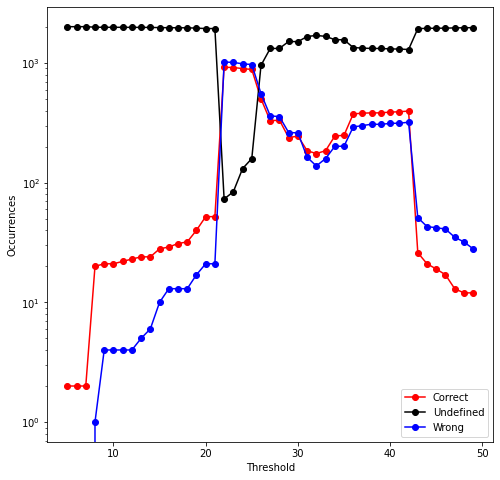

In [24]:
# Plot accuracy
plt.figure(figsize = (8,8)) 
plt.plot(threshold , accuracy_df['Correct'], 'ro-', label='Correct')
plt.plot(threshold , accuracy_df['Undefined'], 'ko-',label='Undefined')
plt.plot(threshold , accuracy_df['Wrong'], 'bo-',label='Wrong')
plt.legend()
plt.yscale('log')
plt.ylabel('Occurrences')
plt.xlabel('Threshold')
plt.show()


In [25]:
tmp            = accuracy_df['Correct'][accuracy_df['Wrong']!=0]/accuracy_df['Wrong'][accuracy_df['Wrong'] != 0]
threshold_loop = threshold[tmp.idxmax()]


print('The best threshold is %s words' %threshold_loop)

# Same as loop
#Win
wc_win = WordCloud(max_words = threshold_loop, width = 1600 , height = 800).generate(" ".join(WIN_text.text))
list_of_words_true = (np.asarray(list(wc_win.words_.keys())))
list_of_freq_true = (np.asarray(list(wc_win.words_.values())))

#Lose
wc_lose = WordCloud(max_words = threshold_loop, width = 1600 , height = 800).generate(" ".join(LOSE_text.text))
list_of_words_lose = (np.asarray(list(wc_lose.words_.keys())))
list_of_freq_lose = (np.asarray(list(wc_lose.words_.values())))

# Find unique values:
# In the lose array 
mask_lose = np.in1d(list_of_words_lose, list_of_words_win, assume_unique=True, invert=True)
new_unique_lose_list = list_of_words_lose[mask_lose]
new_unique_lose_list_freq = list_of_freq_lose[mask_lose]
# In the win array 
mask_win = np.in1d(list_of_words_win, list_of_words_lose, assume_unique=True, invert=True)
new_unique_win_list = list_of_words_win[mask_win]
new_unique_win_list_freq = list_of_freq_win[mask_win]



The best threshold is 8 words


### Wordcloud for the the best threshold and histograms of the word frequency:

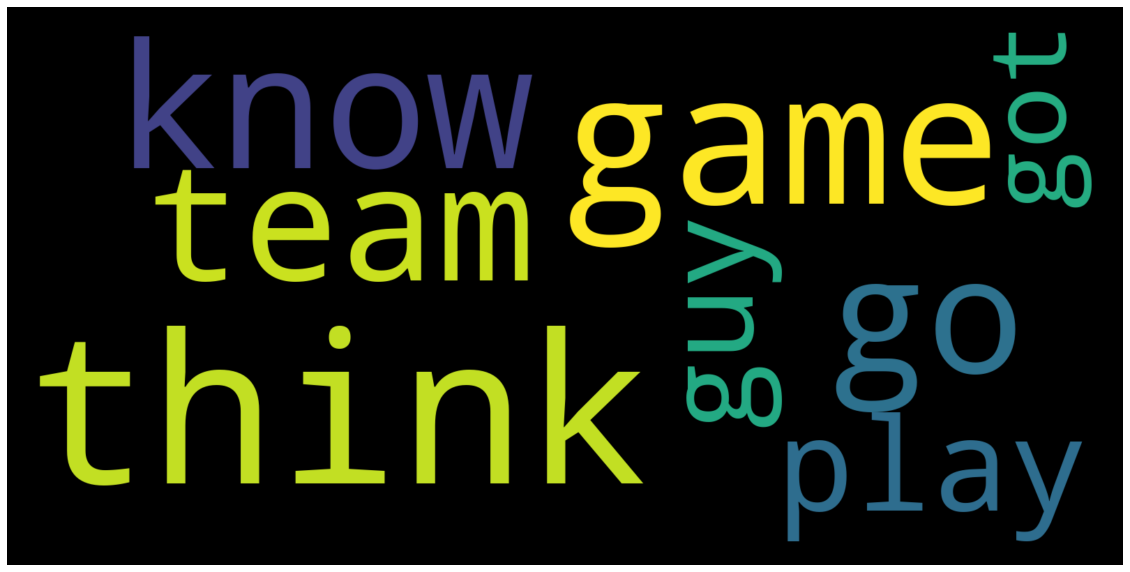

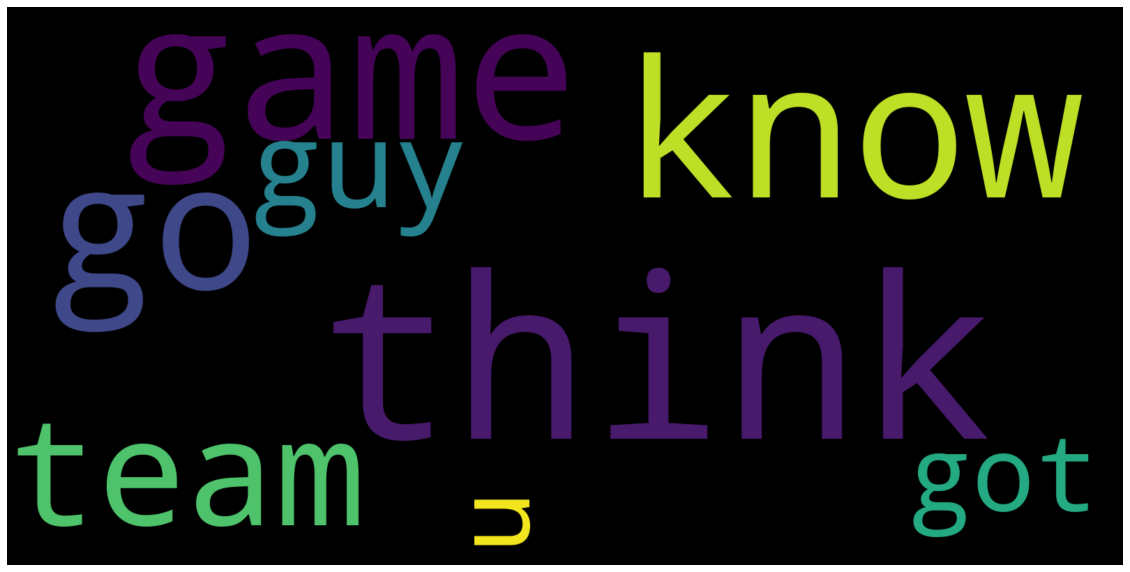

In [26]:
# PLOTS of the BEST threshold value!
plt.figure(figsize = (20,20)) # Text from the true news articles
plt.imshow(wc_win , interpolation = 'bilinear')
plt.axis("off")
plt.show()

plt.figure(figsize = (20,20)) # Text from the fake news articles
plt.imshow(wc_lose , interpolation = 'bilinear')
plt.axis("off")
plt.show()


### Small summary

The wordcloud is not very useful for this analysis, since it does not yield any predictive power....

# 3. Pre-Processing for  LSTM 

In [27]:
#Mixing 
df = df.sample(frac=1)
df.head(10)

,date,name,text,job,year,champions,win
547,2001-06-07,scott stevens,changed game bit didnt keep playing way didnt ...,player,2001,avalanche,0
1479,2014-06-05,anze kopitar,well theyve obviously stepped big way us think...,player,2014,kings,1
680,2010-05-28,mike richards,dont know worked initially peters system aggre...,player,2010,blackhawks,0
1220,2006-06-14,ryan smyth,heads play big time goal right great shot powe...,player,2006,hurricanes,0
401,1998-06-16,mark tinordi,frustrating difficulty play two goal lead that...,player,1998,red wings,0
1953,2000-06-04,ken hitchcock,think depends jamie tomorrow jamie looks like ...,coach,2000,devils,0
1691,1999-06-14,voice,signed cunneyworth summer,player,1999,stars,0
1541,1997-06-02,paul coffey,havent really time think garth playing well us...,player,1997,red wings,0
759,2010-06-05,simon gagne,think little bit sure first game think teams h...,player,2010,blackhawks,0
627,2004-06-04,andrew ference,well think biggest thing whole concept playing...,player,2004,lightning,0


In [28]:
corpus = df['text'].values.tolist()
y      = df['win']

#Setting up vocabulary size
voc_size=1000
onehot_repr=[one_hot(words, voc_size) for words in corpus]


#Setting sentence length
sent_length= 1000
embedded_docs=pad_sequences(onehot_repr, padding='pre', maxlen=sent_length)
print(embedded_docs)


[[  0   0   0 ... 911 685 347]
 [  0   0   0 ...   1 700 659]
 [  0   0   0 ... 120 893 739]
 ...
 [  0   0   0 ... 798 697 252]
 [  0   0   0 ... 143 610 732]
 [  0   0   0 ... 284 742 347]]


In [29]:
# Converting the x and y as array
x_final=np.array(embedded_docs)
y_final=np.array(y)

#Check shape of X and y final
x_final.shape,y_final.shape

((2013, 1000), (2013,))

In [30]:
# Split in train and test set:
x_train, x_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.20, random_state=43)

In [31]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (1610, 1000)
y_train shape: (1610,)
x_test shape: (403, 1000)
y_test shape: (403,)


# 4. LSTM

In [32]:
#Creating the lstm model
embedding_vector_features = 50

model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(50))                            #Adding 50 lstm neurons in the layer
model.add(Dropout(0.5))                        #Dropout Regularization: p=0.5
model.add(Dense(1,activation='sigmoid'))

#Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 50)          50000     
_________________________________________________________________
lstm (LSTM)                  (None, 50)                20200     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 70,251
Trainable params: 70,251
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
# Fitting with 10 epochs and 16 batch size
LSTM_fit = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10,batch_size=16)

Epoch 1/10
101/101 [==============================] - 56s 526ms/step - loss: 0.6898 - accuracy: 0.5317 - val_loss: 0.6889 - val_accuracy: 0.5310
Epoch 2/10
101/101 [==============================] - 46s 453ms/step - loss: 0.6602 - accuracy: 0.6143 - val_loss: 0.6895 - val_accuracy: 0.5261
Epoch 3/10
101/101 [==============================] - 41s 402ms/step - loss: 0.5631 - accuracy: 0.7348 - val_loss: 0.7662 - val_accuracy: 0.5533
Epoch 4/10
101/101 [==============================] - 40s 396ms/step - loss: 0.4757 - accuracy: 0.7807 - val_loss: 0.7632 - val_accuracy: 0.5434
Epoch 5/10
101/101 [==============================] - 40s 396ms/step - loss: 0.3879 - accuracy: 0.8385 - val_loss: 0.8189 - val_accuracy: 0.5608
Epoch 6/10
101/101 [==============================] - 42s 412ms/step - loss: 0.3469 - accuracy: 0.8571 - val_loss: 0.9593 - val_accuracy: 0.5707
Epoch 7/10
101/101 [==============================] - 40s 396ms/step - loss: 0.2883 - accuracy: 0.8901 - val_loss: 1.0110 - val_ac

In [34]:
# Save the model:
!mkdir -p saved_model_LSTM
model.save('saved_model_LSTM/my_LSTM')

INFO:tensorflow:Assets written to: saved_model_LSTM/my_LSTM/assets


INFO:tensorflow:Assets written to: saved_model_LSTM/my_LSTM/assets


# 5. Measuring the performance of the LSTM model

### 5.1 What is the accuracy?

In [35]:
#Evaluate the model:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])

Test Loss: 1.4646226167678833
Test Accuracy: 0.5483871102333069


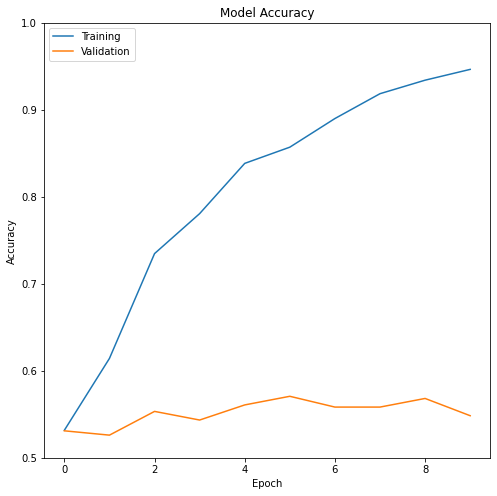

In [36]:
#visualize the model accuracy
plt.figure(figsize=(8,8))
plt.plot(LSTM_fit.history["accuracy"])
plt.plot(LSTM_fit.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Training", "Validation"], loc = "upper left")
plt.ylim([0.5,1])
plt.show()

### 5.2 Prediction

In [37]:
# Predicting from test data
y_pred = (model.predict(x_test) > 0.5).astype("int32")

In [40]:
#Checking for accuracy
accuracy_score(y_test,y_pred)

0.5483870967741935

In [43]:
# Creating classification report 
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.58      0.53      0.56       215
           1       0.51      0.57      0.54       188

    accuracy                           0.55       403
   macro avg       0.55      0.55      0.55       403
weighted avg       0.55      0.55      0.55       403



In [46]:
cm = confusion_matrix(y_test, y_pred)

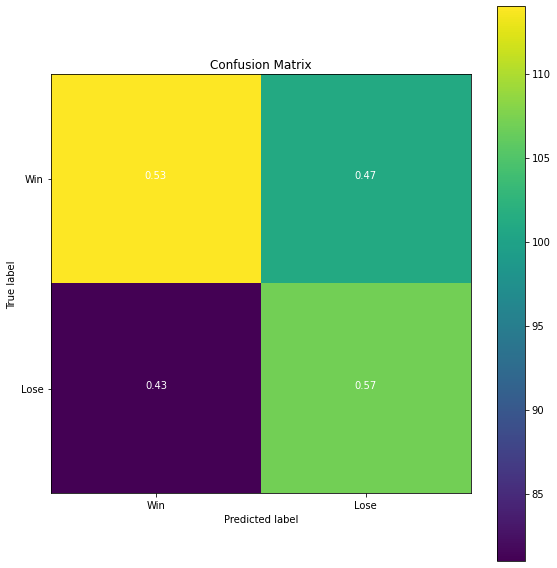

In [47]:
# Plot the confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap='viridis')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(["True","False"]))
plt.xticks(tick_marks, ["Win","Lose"])
plt.yticks(tick_marks, ["Win","Lose"])

#normalize:
cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],2)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Summary

The LSTM as well as the wordcloud did not yield any satisfactory outcome. The predictive power is not much better than a coin flip.... 

# 6. Measuring the performance of the bidirectional LSTM model

Another try with the bidrectional LSTM model. Same training and testing set as before: 

In [48]:
# Creating bidirectional lstm model
embedding_vector_features=40
model_2=Sequential()
model_2.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model_2.add(Bidirectional(LSTM(100))) # Bidirectional LSTM layer
model_2.add(Dropout(0.3))
model_2.add(Dense(1,activation='sigmoid'))
model_2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model_2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 40)          40000     
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               112800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 153,001
Trainable params: 153,001
Non-trainable params: 0
_________________________________________________________________
None


In [49]:
# Fitting the model
LSTMModel_2 = model_2.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
26/26 [==============================] - 50s 2s/step - loss: 0.6929 - accuracy: 0.5292 - val_loss: 0.6913 - val_accuracy: 0.5335
Epoch 2/10
26/26 [==============================] - 43s 2s/step - loss: 0.6869 - accuracy: 0.5453 - val_loss: 0.6914 - val_accuracy: 0.5136
Epoch 3/10
26/26 [==============================] - 44s 2s/step - loss: 0.6732 - accuracy: 0.6422 - val_loss: 0.6959 - val_accuracy: 0.5211
Epoch 4/10
26/26 [==============================] - 49s 2s/step - loss: 0.6087 - accuracy: 0.6876 - val_loss: 0.7420 - val_accuracy: 0.5285
Epoch 5/10
26/26 [==============================] - 54s 2s/step - loss: 0.5261 - accuracy: 0.7460 - val_loss: 0.8164 - val_accuracy: 0.5459
Epoch 6/10
26/26 [==============================] - 44s 2s/step - loss: 0.4612 - accuracy: 0.7919 - val_loss: 0.8931 - val_accuracy: 0.5161
Epoch 7/10
26/26 [==============================] - 46s 2s/step - loss: 0.3948 - accuracy: 0.8317 - val_loss: 0.9305 - val_accuracy: 0.5558
Epoch 8/10
26/26 [==

In [50]:
# Save the model:
!mkdir -p saved_model_LSTM_2
model_2.save('saved_model_LSTM_2/my_LSTM_2')

INFO:tensorflow:Assets written to: saved_model_LSTM_2/my_LSTM_2/assets


INFO:tensorflow:Assets written to: saved_model_LSTM_2/my_LSTM_2/assets


In [51]:
# Predicting from test dataset
y_pred_2 = (model_2.predict(x_test) > 0.5).astype("int32")

In [52]:
#Checking for accuracy
accuracy_score(y_test, y_pred_2)

0.5483870967741935

In [53]:
# Creating classification report 
print(classification_report(y_test,y_pred_2))

              precision    recall  f1-score   support

           0       0.59      0.52      0.55       215
           1       0.51      0.59      0.55       188

    accuracy                           0.55       403
   macro avg       0.55      0.55      0.55       403
weighted avg       0.55      0.55      0.55       403



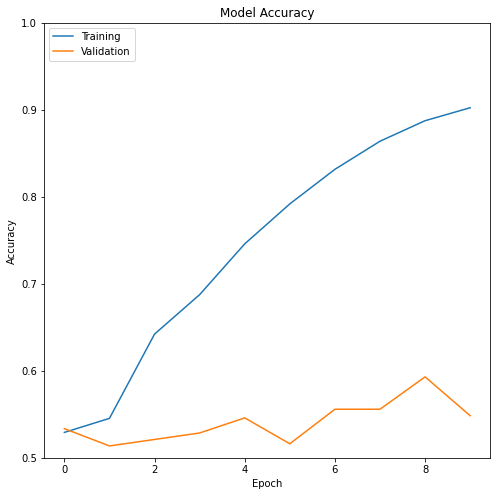

In [54]:
#visualize the model accuracy
plt.figure(figsize=(8,8))
plt.plot(LSTMModel_2.history["accuracy"])
plt.plot(LSTMModel_2.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Training", "Validation"], loc = "upper left")
plt.ylim([0.5,1])
plt.show()

In [55]:
cm = confusion_matrix(y_test, y_pred_2)

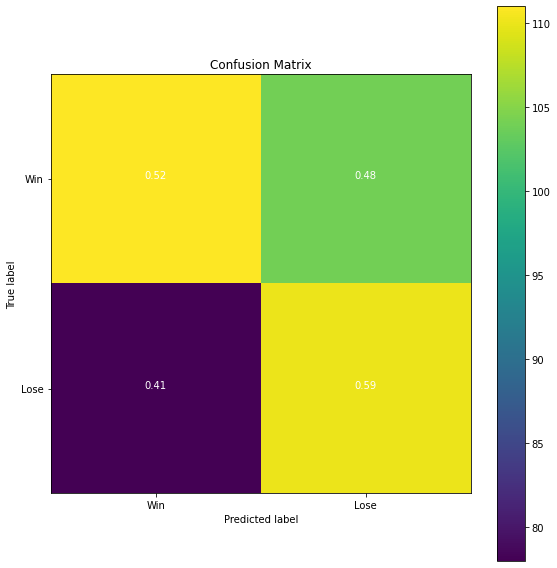

In [56]:
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap='viridis')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(["True","False"]))
plt.xticks(tick_marks, ["Win","Lose"])
plt.yticks(tick_marks, ["Win","Lose"])

#normalize:
cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],2)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Summary:

This is slightly better than before but still far from ideal. Maybe we do not have enough data and the number of epochs have to be also increased....